Investment parameters:

In [318]:
scale = 56
horizon = 0.1

Statistical parameters:

In [319]:
p = 0.95 

Custom functions:

In [320]:
def wrd_div(n, d):
    return n / d if d else 0

def est_coef(x, y): 
    n = np.size(x) 
    m_x, m_y = np.mean(x), np.mean(y) 

    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 

    k = SS_xy / SS_xx 
    b = m_y - k*m_x 
  
    return(b, k)

def power_func(x, a, b):
    return a*np.power(np.array(x), b)

def parab_func(x, a, b, c, d, e):
    return a/np.sqrt(np.power(np.array(x), b)+c*np.array(x)+d)

Import libraries:

In [321]:
from scipy.optimize import curve_fit
from statistics import median
import statsmodels.api as sm

import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
from IPython.display import HTML

Read data:

In [322]:
df = pd.ExcelFile('data/data.xlsx').parse('data')
label = ['TLT', 'SPY', 'GOLD', 'REIT']

Format data:

In [323]:
df = df.dropna(how='any', axis=0)
df['DATE'] =  pd.to_datetime(df['DATE']).dt.date

Show time period and records number:

In [324]:
print('Dates:', list(df['DATE'])[0], 'to', list(df['DATE'])[-1])
print('Number of records:', len(df))

Dates: 2004-11-15 to 2019-11-08
Number of records: 783


Drop date feature:

In [325]:
df = df.drop(['DATE'], axis=1) 

Metrics vice horizon:

In [326]:
df_stat, df_hor = [],[]
p_med, p_std = [], []
p_var = []

for i in range(21): 
    
    df_hor.append(0.1*i)
    
    df_ret = 100*df.apply(np.log).diff(periods=0.1*i*scale)
    p_ret = (1/len(df_ret.columns))*df_ret.sum(axis = 1, skipna = True)
    
    df_med = df_ret.apply(lambda x : x.median())
    df_std = df_ret.apply(lambda x : x.std())
    df_var = df_ret[df_ret <= 0].apply(lambda x : x.abs().quantile(p))
    
    p_med.append(p_ret.median())
    p_std.append(p_ret.std())
    p_var.append(np.quantile(([abs(x) for x in p_ret if x <= 0]), p))
    
    df_stat.append(pd.DataFrame({'Return': df_med, 'Standard': df_std, 'Value at risk': df_var}))

Define statistics:

In [327]:
ass_ret = []
ass_std = []
ass_var =[]

for item in range(4):
    
    ass_ret.append(list([float(df_stat[x]['Return'].iloc[item]) for x in range(21)]))
    ass_std.append(list([float(df_stat[x]['Standard'].iloc[item]) for x in range(21)]))
    ass_var.append(list([float(df_stat[x]['Value at risk'].iloc[item]) for x in range(21)]))

Sharpe ratio:

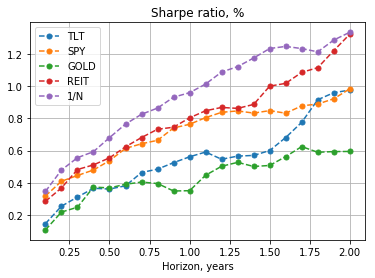

In [328]:
for i in range(4):
    
    z = [wrd_div(x,y) for x, y in zip(ass_ret[i], ass_std[i])][1:] 
    plt.plot(df_hor[1:], z, '--.', label=label[i], markersize=10)

plt.plot(df_hor[1:], [wrd_div(x,y) for x, y in zip(p_med, p_std)][1:], '.--', markersize=10, label='1/N') 
   
plt.title('Sharpe ratio, %')
plt.xlabel('Horizon, years')
plt.legend(loc='upper left')

plt.grid(True)
plt.show()

Value at risk:

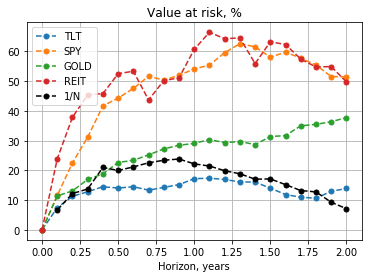

In [338]:
for i in range(4): 
    plt.plot(df_hor, ass_var[i], '--.', label=label[i], markersize=10)

plt.plot(df_hor[1:], p_var[1:], '.--', color='black', markersize=10, label='1/N') 
   
plt.title('Value at risk, %')
plt.xlabel('Horizon, years')
plt.legend(loc='upper left')

plt.grid(True)
plt.show()

Median return vice horizon:

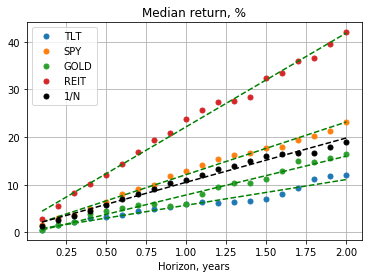

In [331]:
for i in range(4):
    
    plt.plot(df_hor[1:], ass_ret[i][1:], '.', label=label[i], markersize=10)
    x,y = np.unique(df_hor[1:]), np.poly1d(np.polyfit(df_hor[1:], ass_ret[i][1:], 1))
    plt.plot(x, y(x), '--g')

plt.plot(df_hor[1:], p_med[1:], '.', markersize=10, label='1/N', color='black')
x,y = np.unique(df_hor[1:]), np.poly1d(np.polyfit(df_hor[1:], p_med[1:], 1))
plt.plot(x, y(x), '--', color='black')

plt.title('Median return, %')
plt.xlabel('Horizon, years')

plt.legend(loc='upper left')
plt.grid(True)

plt.show()

Metrics of 1/N portfolio:

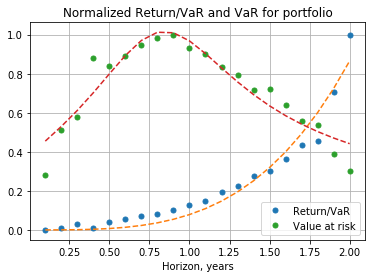

In [339]:
warnings.filterwarnings("ignore")

z = [wrd_div(x,y) for x, y in zip(p_med, p_var)][1:] 

z = (z - min(z))/(max(z)-min(z))
t = (p_var - min(p_var))/(max(p_var)-min(p_var)) 

plt.plot(df_hor[1:], z, '.', markersize=10, label='Return/VaR')
popt, pcov = curve_fit(power_func, df_hor[1:], z)
plt.plot(df_hor[1:], power_func(df_hor[1:], *popt), '--')

plt.plot(df_hor[1:], t[1:], '.', markersize=10, label='Value at risk')
popt, pcov = curve_fit(parab_func, df_hor[1:], t[1:])
plt.plot(df_hor[1:], parab_func(df_hor[1:], *popt), '--')

plt.title('Normalized Return/VaR and VaR for portfolio')
plt.xlabel('Horizon, years')
plt.legend(loc='lower right')

plt.grid(True)
plt.show()